# Student Performance Predictor — Model Training Notebook

This notebook focuses on building a machine learning model to predict student performance in the form of **grades** (A+, A, B+, etc.), using selected behavioral and academic features.

We aim to use only meaningful indicators (like test preparation, lunch type, and writing scores) to prevent the model from simply acting as a calculator. Instead, it will reflect realistic performance predictors.

---

### Goal:
- Train a classification model that predicts a student's **grade**
- Evaluate multiple algorithms
- Choose and save the best one for deployment



### 1. Data Preparation

In this section, we will prepare our dataset for model training by selecting the appropriate input features and the target variable. We are intentionally avoiding using all score-based features to ensure the model does not simply act as a calculator.



#### Required Libraries

In [51]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV

# Save Model
import pickle

# Warnings
import warnings
warnings.filterwarnings('ignore')

#### 1.1 Load Cleaned Dataset

In [15]:
# Load the cleaned dataset
import pandas as pd
df = pd.read_csv("student_data_training.csv") 
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score,total score,average,grade
0,female,group B,bachelor's degree,standard,none,72,72,74,218,72.666667,C+
1,female,group C,some college,standard,completed,69,90,88,247,82.333333,B
2,female,group B,master's degree,standard,none,90,95,93,278,92.666667,A
3,male,group A,associate's degree,free/reduced,none,47,57,44,148,49.333333,D
4,male,group C,some college,standard,none,76,78,75,229,76.333333,B


#### 1.2 Feature and Target Selection
**Input Features:**
- `test_preparation_course`  
- `lunch`  
- `gender`  
- `writing_score`
- `'reading_score'`

**Target Variable:**
- `grade` — the final classification label for performance

In [37]:
# Select Features and Target Variable
features= ['test_preparation_course', 'lunch', 'gender', 'writing_score','reading_score']
target = 'grade'

X = df[features]
y = df[target]

X.head()

,test_preparation_course,lunch,gender,writing_score,reading_score
0,none,standard,female,74,72
1,completed,standard,female,88,90
2,none,standard,female,93,95
3,none,free/reduced,male,44,57
4,none,standard,male,75,78


#### 1.3 Encoding and Scaling features

In [38]:
# Categorical and numerical features
cat_features = ['test_preparation_course', 'lunch', 'gender']
num_features = ['writing_score','reading_score']

# Define ColumnTransformer for encoding + scaling
preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(drop="first"), cat_features),
        ("scaler", StandardScaler(), num_features)
    ]
)

# Apply transformations
X_final = preprocessor.fit_transform(X)
# Check result
print(f"Shape after encoding and scaling: {X_final.shape}")


Shape after encoding and scaling: (1000, 5)


In [39]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Encode the target column (grade)
y_final = label_encoder.fit_transform(y)

# Display the label mapping
label_mapping = {label: idx for idx, label in enumerate(label_encoder.classes_)}
print("Grade to Label Mapping:")
print(label_mapping)

Grade to Label Mapping:
{'A': 0, 'A+': 1, 'B': 2, 'B+': 3, 'C': 4, 'C+': 5, 'D': 6, 'E': 7, 'F': 8}


#### 1.4 Train Test Split

In [40]:
# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

# Check shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (800, 5)
X_test shape: (200, 5)
y_train shape: (800,)
y_test shape: (200,)


### 2. Model Training & Evaluation
With our data cleaned, encoded, scaled, and split into training and testing sets, we now move into the core machine learning phase.
We will:
- Train multiple classification models
- Evaluate them on the test set
- Select the one with the best performance for deployment



#### 2.1 Training Multiple Classifiers
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier
- Support Vector Classifier (SVC)
- K-Nearest Neighbors (KNN)

In [45]:
# Initialize classifiers
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVC": SVC(),
    "KNN": KNeighborsClassifier()
}

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: Accuracy = {acc:.4f}")



Logistic Regression: Accuracy = 0.7500
Decision Tree: Accuracy = 0.7550
Random Forest: Accuracy = 0.8050
SVC: Accuracy = 0.8250
KNN: Accuracy = 0.7950


#### 2.2 Evaluate Best Performing Model

In [47]:
# Train the final SVC model
svc_model = SVC(kernel='rbf', C=100, gamma=0.01)
svc_model.fit(X_train, y_train)

# Predict
y_pred = svc_model.predict(X_test)

# Evaluate
print(f"Test Accuracy of SVC: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Test Accuracy of SVC: 0.8400

Classification Report:

              precision    recall  f1-score   support

           A       0.80      0.67      0.73         6
          A+       1.00      0.75      0.86         4
           B       0.78      0.90      0.84        42
          B+       0.79      0.85      0.81        13
           C       0.91      0.90      0.91        59
          C+       0.84      0.76      0.80        55
           D       0.82      0.93      0.88        15
           E       0.00      0.00      0.00         3
           F       0.75      1.00      0.86         3

    accuracy                           0.84       200
   macro avg       0.74      0.75      0.74       200
weighted avg       0.83      0.84      0.83       200



#### 2.3 Cross Validation

In [ ]:
# Use the best model so far: SVC
svc_model = SVC(kernel='rbf', C=100, gamma=0.01)

# Set up Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Get cross-validation scores
cv_scores = cross_val_score(svc_model, X_final, y_final, cv=skf)

# Display results
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores).round(4))


Cross-Validation Scores: [0.85 0.87 0.86 0.85 0.8 ]
Mean CV Accuracy: 0.846


#### 2.4 Hyperparameter Tuning using GridSearchCV

In [50]:
# Define parameter grid
param_grid = {
    'C': [1, 10, 100],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# Initialize SVC model
svc = SVC()

# GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test Accuracy:", round(test_accuracy, 4))


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best Cross-Validation Accuracy: 0.8400000000000001
Test Accuracy: 0.845


#### 2.5 Model Evaluation and Classification Report

After selecting the best hyperparameters through GridSearchCV, we now evaluate the final SVC model's performance using precision, recall, F1-score, and the confusion matrix.


Classification Report:
              precision    recall  f1-score   support

           A       0.80      0.67      0.73         6
          A+       1.00      0.75      0.86         4
           B       0.79      0.90      0.84        42
          B+       0.79      0.85      0.81        13
           C       0.91      0.90      0.91        59
          C+       0.85      0.80      0.82        55
           D       0.81      0.87      0.84        15
           E       0.00      0.00      0.00         3
           F       0.75      1.00      0.86         3

    accuracy                           0.84       200
   macro avg       0.74      0.75      0.74       200
weighted avg       0.84      0.84      0.84       200



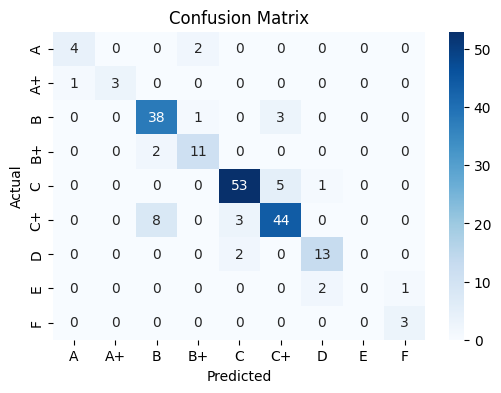

In [53]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict on test set
y_pred = best_model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### 3. Saving the Trained Model

#### 3.1 Saving the Trained Model and Transformers
- The **trained model** (`best_model`)
- The **Label Encoder** used to encode grades
- The **ColumnTransformer** (`preprocessor`) that handles scaling and one-hot encoding


In [ ]:
import os
import joblib

# Directory to store saved files
os.makedirs("../artifacts", exist_ok=True)

# Save the best model
joblib.dump(best_model, "../artifacts/svc_model.pkl")

# Save the label encoder for target variable
joblib.dump(label_encoder, "../artifacts/label_encoder.pkl")

# Save the preprocessor (encoder + scaler)
joblib.dump(preprocessor, "../artifacts/preprocessor.pkl")

print("Model, Label Encoder, and Preprocessor saved in 'artifacts/' folder.")


Model, Label Encoder, and Preprocessor saved in 'artifacts/' folder.


#### 3.2 Load and Test Saved Model  
We will load the saved SVC model, preprocessor, and label encoder from the `artifacts` folder and test it using a sample input.


In [57]:
# Load saved components
loaded_model = joblib.load("../artifacts/svc_model.pkl")
loaded_preprocessor = joblib.load("../artifacts/preprocessor.pkl")
loaded_label_encoder = joblib.load("../artifacts/label_encoder.pkl")

# Sample input (adjust as needed)
sample_data = pd.DataFrame({
    'test_preparation_course': ['completed'],
    'lunch': ['standard'],
    'gender': ['female'],
    'writing_score': [85],
    'reading_score': [88]
})

# Preprocess sample input
sample_processed = loaded_preprocessor.transform(sample_data)

# Predict
predicted_label = loaded_model.predict(sample_processed)

# Decode label
predicted_grade = loaded_label_encoder.inverse_transform(predicted_label)
print("Predicted Grade:", predicted_grade[0])


Predicted Grade: B


#### 3.3 Wrap Prediction Logic into a Function  
To make deployment and testing easier, we'll create a function that takes in user inputs, preprocesses the data, performs prediction, and returns the predicted grade.


In [59]:
def predict_grade(test_prep, lunch, gender, writing_score, reading_score):
    # Load saved components
    model = joblib.load("../artifacts/svc_model.pkl")
    preprocessor = joblib.load("../artifacts/preprocessor.pkl")
    label_encoder = joblib.load("../artifacts/label_encoder.pkl")
    
    # Prepare the input as DataFrame
    input_df = pd.DataFrame({
        'test_preparation_course': [test_prep],
        'lunch': [lunch],
        'gender': [gender],
        'writing_score': [writing_score],
        'reading_score': [reading_score]
    })
    
    # Preprocess input
    transformed_input = preprocessor.transform(input_df)
    
    # Predict and decode
    prediction = model.predict(transformed_input)
    grade = label_encoder.inverse_transform(prediction)[0]
    
    return grade

predict_grade("completed", "standard", "female", 85, 88)


'B'

### 4. Conclusion
In this notebook, we built a classification model to predict student performance (in terms of grades) based on parameters such as:
- Test preparation course
- Lunch type
- Gender
- Writing score
- Reading score

**We performed the following:**
- Encoded and scaled features using ColumnTransformer
- Encoded target grades using LabelEncoder
- Trained multiple models and evaluated their performance
- Tuned hyperparameters using GridSearchCV for the Support Vector Classifier (SVC)
- Achieved a final test accuracy of `84.5%`
